In [124]:
# New optimal hyperparameters
# model        <__main__.AlternatingLeastSquare object at 0x1...
# n_factors                                                   40
# n_iter                                                      95
# reg                                                        0.1
# test_mse                                               10.0342
# train_mse                                              4.72275
# dtype: object
# Regularization: 1.0
# Regularization: 10.0
# Regularization: 100.0
# Factors: 80
# Regularization: 0.01
# Regularization: 0.1
# Regularization: 1.0
# Regularization: 10.0
# Regularization: 100.0

In [2]:
import pandas as pd
import numpy as np
import random as rn
import time
np.random.seed(0)
import requests

In [3]:
# tag = pd.read_csv('movielens-20m-dataset/tag.csv')
# link = pd.read_csv('movielens-20m-dataset/link.csv')
movies = pd.read_csv('../data/movie.csv')
rating = pd.read_csv('../data/rating.csv')
# tags = pd.read_csv('movielens-20m-dataset/genome_tags.csv')
# scores = pd.read_csv('movielens-20m-dataset/genome_scores.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
rating.tail()

,userId,movieId,rating,timestamp
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24
20000262,138493,71619,2.5,2009-10-17 20:25:36


In [6]:
movies[movies['movieId'] == 69526]

,movieId,title,genres
13876,69526,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX


In [311]:
class AlternatingLeastSquare(object):
    USERS_MATRIX = 'users_matrix'
    MOVIES_MATRIX = 'movies_matrix'
    
    def __init__(self, characteristic_matrix, latent_feature_count=50, users_reg=0.0, movies_reg=0.0):
        self.characteristic_matrix = characteristic_matrix
        self.latent_feature_count = latent_feature_count
        self.users_reg = users_reg
        self.movies_reg = movies_reg
        self.total_users, self.total_movies = self.characteristic_matrix.shape
    
    @staticmethod
    def calculate_mean_squared_error(predicted, actual):
        # mse = (np.square(predicted - actual)).mean(axis=ax)
        predicted = predicted[actual.nonzero()].flatten()
        actual = actual[actual.nonzero()].flatten()
        return ((predicted - actual) ** 2).mean()


    def train(self, iters=50):
        self.users_matrix = np.random.random((self.total_users, self.latent_feature_count))
        self.movies_matrix = np.random.random((self.total_movies, self.latent_feature_count))
        self.train_continue(iters)
    
    def train_continue(self, iters=5):
        for i in range(iters):
            self.users_matrix = self.train_step(self.users_matrix, self.movies_matrix, AlternatingLeastSquare.USERS_MATRIX)
            self.movies_matrix = self.train_step(self.movies_matrix, self.users_matrix, AlternatingLeastSquare.MOVIES_MATRIX)
            
    def train_step(self, variable_matrix, constant_matrix, chance):
        
        if chance == AlternatingLeastSquare.USERS_MATRIX:
            y_dot_y = constant_matrix.T.dot(constant_matrix)
            lambda_i = np.identity(y_dot_y.shape[0]) * self.users_reg
            
            for user_index in range(variable_matrix.shape[0]):
                variable_matrix[user_index, :] = np.linalg.solve(y_dot_y + lambda_i,\
                                                                 self.characteristic_matrix[user_index, :].dot(constant_matrix))
            
        elif chance == AlternatingLeastSquare.MOVIES_MATRIX:
            x_dot_x = constant_matrix.T.dot(constant_matrix)
            lambda_i = np.identity(x_dot_x.shape[0]) * self.movies_reg
            
            for movie_index in range(variable_matrix.shape[0]):
                variable_matrix[movie_index, :] = np.linalg.solve(x_dot_x + lambda_i,\
                                                                 self.characteristic_matrix[:, movie_index].T.dot(constant_matrix))
        return variable_matrix
    
    def predict(self, user, movie):
        return self.users_matrix[user, :].dot(self.movies_matrix[movie, :].T)
    
    def predict_all(self):
        # predictions = np.zeros((self.total_users, self.total_movies))
        # for user in xrange(self.total_users):
        #     for movie in xrange(self.total_movies):
        #         predictions[user, movie] = self.predict(user, movie)

        predictions = self.users_matrix.dot(self.movies_matrix.T)
                
        return predictions
    
    def get_train_test_error(self, test_data, iters_list):
        test_error = []
        train_error = []
        iters_count_till_now = 0
        for iters in iters_list:
            start = time.time()
            remaining_iters = iters - iters_count_till_now
            if remaining_iters < 1:
                continue
            if iters_count_till_now == 0:
                self.train(iters=remaining_iters)
            else:
                self.train_continue(iters=remaining_iters)
            iters_count_till_now += remaining_iters
            predicted = self.predict_all()
            end = time.time()
            test_error.append(AlternatingLeastSquare.calculate_mean_squared_error(predicted, test_data))
            train_error.append(AlternatingLeastSquare.calculate_mean_squared_error(predicted, self.characteristic_matrix))
            print "After [%d] itertions, Time taken [%d] secs, Training error: [%f], Test error: [%f]"%(iters_count_till_now, end-start, train_error[-1], test_error[-1])
        return train_error, test_error


In [200]:
def loadDatasets():
    movies = pd.read_csv('movielens-20m-dataset/movie.csv')
    ratings = pd.read_csv('movielens-20m-dataset/rating.csv')
    return movies, ratings

In [315]:
def preprocessData(user_movie_rating, factor=0.5):
    size = user_movie_rating.shape[0]
    partition_index = int(size*factor)
    subset = user_movie_rating.iloc[:partition_index, :]
    subset = subset.dropna()
    subset = subset.drop('timestamp', axis=1)
    return subset

In [ ]:
def train_test_split(characteristic_matrix):
    test = np.zeros(characteristic_matrix.shape)
    train = characteristic_matrix.copy()
    for user in xrange(characteristic_matrix.shape[0]):
        test_indexes = np.random.choice(characteristic_matrix[user, :].nonzero()[0], size=10, replace=False)
        train[user, test_indexes] = 0.0
        test[user, test_indexes] = characteristic_matrix[user, test_indexes]
        
    assert(np.all((train * test) == 0)) 
    return train, test

In [157]:
def getCharateristicMatrix(user_movie_rating):
    characteristic_df = user_movie_rating.pivot('userId', 'movieId', values='rating')
    characteristic_df = characteristic_df.fillna(0)
    characteristic_matrix = characteristic_df.as_matrix()
    characteristic_df.index.name = None
    
    movie_mapping_df = pd.DataFrame({'matrix_index': range(characteristic_df.shape[1]), 'movie_id': characteristic_df.columns})
    movie_mapping = dict(zip(movie_mapping_df.matrix_index, movie_mapping_df.movie_id))
    r_movie_mapping = dict(zip(movie_mapping_df.movie_id, movie_mapping_df.matrix_index))
    
    user_mapping_df = pd.DataFrame({'matrix_index': range(characteristic_df.shape[0]), 'user_id': characteristic_df.index.tolist()})
    user_mapping = dict(zip(user_mapping_df.matrix_index, user_mapping_df.user_id))
    r_user_mapping = dict(zip(user_mapping_df.user_id, user_mapping_df.matrix_index))
    mappings = {
        'user_mapping': user_mapping,
        'movie_mapping': movie_mapping,
        'r_user_mapping': r_user_mapping,
        'r_movie_mapping': r_movie_mapping
    }
    return characteristic_matrix, mappings



In [181]:
def getUserIdsFromMatrixIndexes(matrix_indexes, user_mapping, preserve_order=True):
    user_ids = []
    for index in matrix_indexes:
        user_ids.append(user_mapping[index])
    return user_ids

def getMovieIdsFromMatrixIndexes(matrix_indexes, movie_mapping, preserve_order=True):
    movie_ids = []
    for index in matrix_indexes:
        movie_ids.append(movie_mapping[index])
    return movie_ids

In [148]:
def getWatchedMovies(user_id, user_movie_rating_df):
    rated_movies = user_movie_rating_df[user_movie_rating_df['userId'] == user_id]['movieId'].values.tolist()
    return rated_movies

In [287]:
def filterWatchedMovies(user_id, ordered_movie_ids, user_movie_rating_df):
    all_movies = set(ordered_movie_ids)
    rated_movies = set(getWatchedMovies(user_id, user_movie_rating_df))
    print "Watched : ", len(rated_movies)
    not_watched = all_movies - rated_movies
    ordered_not_watched = [movie_id for movie_id in ordered_movie_ids if movie_id not in rated_movies]
    return ordered_not_watched
    

In [208]:
def displayMovies(movie_ids, movies_df):
    for movie_id in movie_ids:
        print movies_df[movies_df['movieId'] == movie_id].values.tolist()[0]

In [313]:
def main():
    movies, all_ratings = loadDatasets()
    ratings = preprocessData(all_ratings, factor=0.001)
    characteristic_matrix, mappings = getCharateristicMatrix(ratings)
    train_matrix, test_matrix = train_test_split(characteristic_matrix)
    
    als = AlternatingLeastSquare(train_matrix, latent_feature_count=40, users_reg=0.1, movies_reg=0.1)
    als.train(iters=95)
    
    movie_ids = recommendMoviesTo(31, als, mappings, limit=300)
    print len(movie_ids)
    
    f_movie_ids = filterWatchedMovies(31, movie_ids, ratings)
    print len(f_movie_ids)
    
    displayMovies(f_movie_ids_anime, movies)

In [314]:
main()

20000263
20000
(20000, 4)
300
Watched :  246
65
[1175, 'Delicatessen (1991)', 'Comedy|Drama|Romance']
[1909, 'X-Files: Fight the Future, The (1998)', 'Action|Crime|Mystery|Sci-Fi|Thriller']
[1282, 'Fantasia (1940)', 'Animation|Children|Fantasy|Musical']
[92259, 'Intouchables (2011)', 'Comedy|Drama']
[497, 'Much Ado About Nothing (1993)', 'Comedy|Romance']
[300, 'Quiz Show (1994)', 'Drama']
[508, 'Philadelphia (1993)', 'Drama']
[596, 'Pinocchio (1940)', 'Animation|Children|Fantasy|Musical']
[1245, "Miller's Crossing (1990)", 'Crime|Drama|Film-Noir|Thriller']
[2085, '101 Dalmatians (One Hundred and One Dalmatians) (1961)', 'Adventure|Animation|Children']
[1095, 'Glengarry Glen Ross (1992)', 'Drama']
[2788, "Monty Python's And Now for Something Completely Different (1971)", 'Comedy']
[4701, 'Rush Hour 2 (2001)', 'Action|Comedy']
[161, 'Crimson Tide (1995)', 'Drama|Thriller|War']
[266, 'Legends of the Fall (1994)', 'Drama|Romance|War|Western']
[1293, 'Gandhi (1982)', 'Drama']
[1086, 'Dial 

In [ ]:
from IPython.display import HTML
from IPython.display import display

def display_top_k_movies(similarity, mapper, movie_idx, base_url, api_key, k=5):
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]
    images = ''
    k_ctr = 0
    # Start i at 1 to not grab the input movie
    i = 1
    while k_ctr < 5:
        movie = mapper[movie_indices[i]]
        poster = get_poster(movie, base_url, api_key)
        if poster != '':
            images += "<img style='width: 120px; margin: 0px; \
                      float: left; border: 1px solid black;' src='%s' />"\
                      % poster
            k_ctr += 1
        i += 1
    display(HTML(images))

def compare_recs(als_similarity, sgd_similarity, mapper,\
                 movie_idx, base_url, api_key, k=5):
    # Display input
    display(HTML('<font size=5>'+'Input'+'</font>'))
    input_poster = get_poster(mapper[movie_idx], base_url, api_key)
    input_image = "<img style='width: 120px; margin: 0px; \
                      float: left; border: 1px solid black;' src='%s' />" \
                  % input_poster
    display(HTML(input_image))
    # Display ALS Recs
    display(HTML('<font size=5>'+'ALS Recs'+'</font>'))
    display_top_k_movies(als_similarity, idx_to_movie,\
                         movie_idx, base_url, api_key)
    # Display SGD Recs
    display(HTML('<font size=5>'+'SGD Recs'+'</font>'))
    display_top_k_movies(sgd_similarity, idx_to_movie,\
                         movie_idx, base_url, api_key)

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, error, label):
    plt.plot(iter_array, error, label=label, linewidth=5)
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);
    plt.plot()

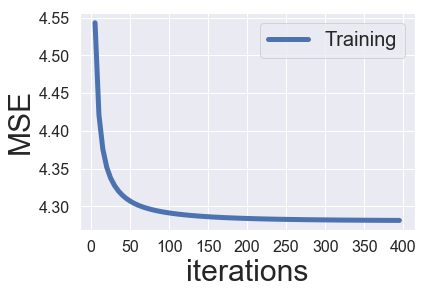

In [20]:
plot_learning_curve(iters_list, train_error, 'Training')

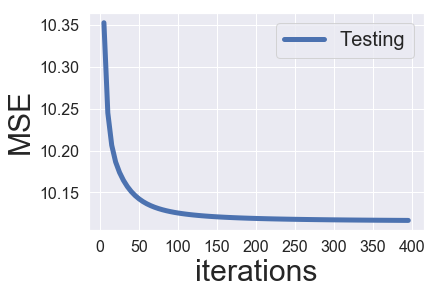

In [21]:
plot_learning_curve(iters_list, test_error, 'Testing')

In [27]:
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = list(range(5, 100, 5))

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularization: {}'.format(reg)
        als = AlternatingLeastSquare(train, latent_feature_count=fact, users_reg=0.3, movies_reg=0.3)
        train_mse, test_mse = als.get_train_test_error(test, iter_array)
        min_idx = np.argmin(test_mse)
        if test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = train_mse[min_idx]
            best_params['test_mse'] = test_mse[min_idx]
            best_params['model'] = als
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 5
Regularization: 0.01
New optimal hyperparameters
model        <__main__.AlternatingLeastSquare object at 0x1...
n_factors                                                    5
n_iter                                                      95
reg                                                       0.01
test_mse                                               10.6545
train_mse                                              7.70133
dtype: object
Regularization: 0.1
New optimal hyperparameters
model        <__main__.AlternatingLeastSquare object at 0x1...
n_factors                                                    5
n_iter                                                      95
reg                                                        0.1
test_mse                                               10.6544
train_mse                                              7.70123
dtype: object
Regularization: 1.0
New optimal hyperparameters
model        <__main__.AlternatingLeastSquare object at 0x1.

In [233]:
# m = movies[movies['genres'].str.contains('Animation')]['movieId'].values.tolist()

In [346]:
def fetchImageUrl(movie_id):
    url = "https://www.imdb.com/title/tt%d/"%(movie_id)
    resp = requests.get(url)
    if resp.status_code >= 400:
        return ''
    img_url = ''
    try:
        bs = BeautifulSoup(resp.text)
        poster_div = bs.findAll("div", {"class": "poster"})[0]
        poster_img = poster_div.findAll('img')[0]
        img_url = poster_img['src']
    except:
        pass
    return img_url

In [347]:
fetchImageUrl(8291224)

'https://m.media-amazon.com/images/M/MV5BMWU4ZjNlNTQtOGE2MS00NDI0LWFlYjMtMmY3ZWVkMjJkNGRmXkEyXkFqcGdeQXVyNjE1OTQ0NjA@._V1_UY268_CR2,0,182,268_AL_.jpg'

In [344]:
display(HTML(img))

In [ ]:
# https://www.imdb.com/title/tt8191224/?ref_=nv_sr_1

In [54]:
lines = []
count = 0
with open('../data/title.akas.tsv') as infile:
    for line in infile:
        line = line.split('\t')
        print line
        if count > 3:
            break
#         if line[3] == 'US' and int(line[0][2:]) > 230314:
#             record_to_insert = (line[0], line[2][:200], line[3])
#             insert(record_to_insert)
        count += 1
        if count % 1000 == 0:
            pass
#             conn.commit()

['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle\n']
['tt0000001', '1', 'Carmencita - spanyol t\xc3\xa1nc', 'HU', '\\N', 'imdbDisplay', '\\N', '0\n']
['tt0000001', '2', '\xce\x9a\xce\xb1\xcf\x81\xce\xbc\xce\xb5\xce\xbd\xcf\x83\xce\xaf\xcf\x84\xce\xb1', 'GR', '\\N', '\\N', '\\N', '0\n']
['tt0000001', '3', '\xd0\x9a\xd0\xb0\xd1\x80\xd0\xbc\xd0\xb5\xd0\xbd\xd1\x81\xd0\xb8\xd1\x82\xd0\xb0', 'RU', '\\N', '\\N', '\\N', '0\n']
['tt0000001', '4', 'Carmencita', 'US', '\\N', '\\N', '\\N', '0\n']


In [ ]:
print "DONE"

In [52]:
conn.commit()

In [28]:
lines = map(lambda x: x.split('\t'),lines)

In [46]:
def insert(record_to_insert):
    postgres_insert_query = """ INSERT INTO movies (imdb_id, name, language) VALUES (%s,%s,%s)"""
    cur.execute(postgres_insert_query, record_to_insert)

In [11]:
import psycopg2

/usr/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [44]:
conn = psycopg2.connect("dbname='movie_recommender' user='postgres' host='localhost' port=5432 password=''")

In [45]:
cur = conn.cursor()

In [34]:
cur.execute("select * from movies;")

In [35]:
rows = cur.fetchall()
for row in rows:
    print "   ", row

In [42]:
cur.close()

In [43]:
conn.close()